In [1]:
import deblend
import om10
import desc.slrealizer

/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


this is rv


/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


this is rv


In [2]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [3]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1900
Number of these with 4 images =  290
Number of these with i3 < 22 =  122


OM10: Extracted OM10 lens number 41837502:
 LENSID  FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
-------- -------- ---- ----- ... ------------- ------------- -------------
41837502        0    2 1.162 ...         21.95 21.7357388199 22.3025716205
Deblending starts.....
The system looks like this....
In 'draw_model', mag_ratio, quasar_alpha, lens_alpha = 1.9707563323 0.507419402191 1


/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


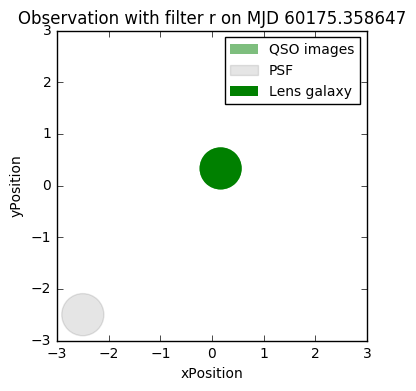

In [5]:
realizer.deblend(lensID=k)

Populating the interactive namespace from numpy and matplotlib


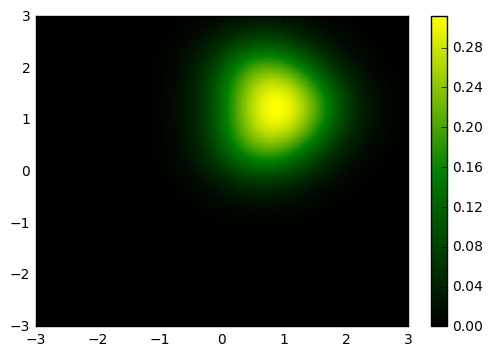

In [34]:
#deblender sample
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

number_of_rows = 1000
number_of_columns = 1000
image = [[0]*number_of_rows for _ in range(number_of_columns)]
image1 = [[0]*number_of_rows for _ in range(number_of_columns)]

x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

rv = scipy.stats.multivariate_normal([3, 1]) # xPos, yPos, covariance matrix whose entrees are just FWHM
#print rv
image = image + rv.pdf(pos) # BUG: multiply flux ratio
# save peak value
rv = scipy.stats.multivariate_normal([2, 2])
image1 = image + rv.pdf(pos)
rv = scipy.stats.multivariate_normal([1, 1])
image1 = image1 + rv.pdf(pos)
#print image # this is a 2d array

cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', ['black', 'green', 'yellow'], 256)
img2 = plt.imshow(image1, interpolation='nearest', cmap = cmap2, origin='lower', extent=[-3, 3, -3, 3], aspect = "auto")

plt.colorbar(img2,cmap=cmap2)
plt.show()

In [ ]:
#deblend fit gaussian
#pick peaks out and then start fitting
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m